In [1]:
# kaggle data used:
# flickr8k dataset:- https://www.kaggle.com/adityajn105/flickr8k
# glove embeddings:- https://www.kaggle.com/incorpes/glove6b200d

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

In [3]:
from pickle import dump, load
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model, load_model,Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout

from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.models import Model
from glob import glob

from tqdm import tqdm
import nltk

# Reading Image Data

In [4]:
img_path="../input/flickr8k/Images/"
images = glob(img_path+'*.jpg')
len(images)

8091

In [5]:
images[6]

'../input/flickr8k/Images/3097776588_312932e438.jpg'

# Extractime image features using VGG16

In [6]:
# Downloading and building the VGG16 model

model=VGG16()
model.layers.pop()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

553467904/553467096 [==============================] - 18s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [7]:
'''
features = {}

for i in tqdm(images):
    img=load_img(i,target_size=(224, 224,3))
    img=img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img=preprocess_input(img)
    feature = model.predict(img)
    feature=feature.reshape((-1,))
    
    img_id=i.replace("../input/flickr8k/Images/","")
    
    features[img_id]=feature

dump(features, open("features.p","wb"))
'''

'\nfeatures = {}\n\nfor i in tqdm(images):\n    img=load_img(i,target_size=(224, 224,3))\n    img=img_to_array(img)\n    img = np.expand_dims(img, axis=0)\n    img=preprocess_input(img)\n    feature = model.predict(img)\n    feature=feature.reshape((-1,))\n    \n    img_id=i.replace("../input/flickr8k/Images/","")\n    \n    features[img_id]=feature\n\ndump(features, open("features.p","wb"))\n'

In [8]:
features = load(open("../input/my-images/features.p","rb"))

In [9]:
(features[list(features.keys())[0]]).shape, (features[list(features.keys())[254]]).shape

((4096,), (4096,))

# Text preprocessing

### reading caption file

In [10]:
captions_txt = open("../input/flickr8k/captions.txt", 'rb').read().decode('utf-8')
img_cap_corpus=captions_txt.split('\n')
img_cap_corpus.pop(0)

img_cap_corpus[:12]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow with her hands in a 

### combining the images data and caption data in a dictionary

In [11]:
img_cap_dic={}
for line in img_cap_corpus:   
    img_cap = line.split(',')
    
    if(len(img_cap)>=2):
        img_id=img_cap[0]
        caption=img_cap[1]

        if img_id not in img_cap_dic:
            img_cap_dic[img_id] = [caption]
        else:
            img_cap_dic[img_id].append(caption)

            
list(img_cap_dic.keys())[254], img_cap_dic[list(img_cap_dic.keys())[254]]

('1295669416_21cabf594d.jpg',
 ['A girl dressed in a red and black top with black pants is sitting on a wall .',
  'A girl in a red and black striped shirt sits on a brick wall in front of a tropical plant .',
  'A girl wearing a red and black striped shirt is sitting on a brick wall near a flower garden .',
  'A lady in a red and black striped shirt is sitting on a retaining wall .',
  'A woman in semi-formal attire is sitting on a concrete wall .'])

### cleaning text and adding end points to captions

In [12]:
def preprocessed(text):
    modified = text.lower()    
    
    tokens = modified.split(' ')
    for word in tokens:                   # this part is removing single letter words
        if len(word)<2:                   # because, there is no embedding for the letter 'a' in glove200
            tokens.remove(word)          
    modified=" ".join(tokens)
    
    if modified.split(' ')[0]!='start_':
        modified = 'start_ ' + modified + ' _end'
        
    return modified

In [13]:
for k, caps in img_cap_dic.items():
    for cap in caps:
        img_cap_dic[k][caps.index(cap)] = preprocessed(cap)

list(img_cap_dic.keys())[254], img_cap_dic[list(img_cap_dic.keys())[254]]

('1295669416_21cabf594d.jpg',
 ['start_ girl dressed in red and black top with black pants is sitting on wall _end',
  'start_ girl in red and black striped shirt sits on brick wall in front of tropical plant _end',
  'start_ girl wearing red and black striped shirt is sitting on brick wall near flower garden _end',
  'start_ lady in red and black striped shirt is sitting on retaining wall _end',
  'start_ woman in semi-formal attire is sitting on concrete wall _end'])

### maximum length of caption

In [14]:
max_length=0
for caps in img_cap_dic.values():
    for cap in caps:
        if max_length<len(cap.split(" ")):
            max_length=len(cap.split(" "))

max_length   

31

### tokenizing captions and padding

In [15]:
# creating dictionary

tokenizer = Tokenizer(num_words=None,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',oov_token='<oov>')

for k,caps in tqdm(img_cap_dic.items()):
    tokenizer.fit_on_texts(caps)
    
vocab_size=len(tokenizer.word_index)+1

100%|██████████| 8091/8091 [00:44<00:00, 183.31it/s]


In [16]:
vocab_size

8317

In [17]:
# specifying tokens and padding

trunc_type = 'post'
padding_type = 'post'

sequence={}
for k,caps in tqdm(img_cap_dic.items()):
        sequence[k]=pad_sequences(tokenizer.texts_to_sequences(caps), maxlen=max_length, padding=padding_type, truncating=trunc_type)
        tokenizer.texts_to_sequences(caps)

100%|██████████| 8091/8091 [00:01<00:00, 5839.37it/s]


In [18]:
q = 53
(sequence[list(sequence.keys())[q]]).shape, list(sequence.keys())[q], sequence[list(sequence.keys())[q]]

((5, 31),
 '1072153132_53d2bb1b60.jpg',
 array([[   3,   15,    8,   14,    9,  356,  106,    4,  241,    2,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   3,    9,    8,  140,   40,    2,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   3,   52,    9,    7,   45,   20,  164,  310,  744,   23,  156,
            2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   3,    9,  247,   36,  269,  140,   40,   33,  127,   53,    2,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   3, 1732,    9,   45,   20,  164,  140,   40,    4,  127,   53,
            2,    0,    0,   

# Data Generator

In [19]:
for key, desc_list in img_cap_dic.items():
    #retrieve photo features
    feature = features[key][0]
    
features[key]

array([0.       , 0.       , 0.9586388, ..., 0.       , 0.       ,
       0.       ], dtype=float32)

In [20]:
#  generator = data_generator(img_cap_dic, features, tokenizer, max_length, number_pics_per_bath)
# This function will be used while training

#'''
def data_generator(descriptions, features, tokenizer, max_length,batch):
    X1, X2, y = list(), list(), list()
    n=0
    
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            #retrieve photo features
            feature = features[key]            
            
            # walk through each description for the image
            for desc in desc_list:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([desc])[0]
                # split one sequence into multiple X,y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

            
             # yield the batch data
            if n==batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = list(), list(), list()
                n=0
            
#'''

# Loading glove embedding vectors

In [21]:
embeddings = {} 
glove = open('../input/glove6b200d/glove.6B.200d.txt', 'r', encoding = 'utf-8').read() 

In [22]:
#'''
for line in tqdm(glove.split("\n")): 
    values = line.split(" ") 
    word = values[0] 
    indices = np.asarray(values[1: ], dtype = 'float32') 
    embeddings[word] = indices 
#'''

100%|██████████| 400001/400001 [00:15<00:00, 25037.47it/s]


In [23]:
embedding_dim = 200
emb_matrix = np.zeros((vocab_size, embedding_dim)) 
for word, i in tokenizer.word_index.items(): 
    embedding_vec = embeddings.get(word) 
    if embedding_vec is not None: 
        emb_matrix[i] = embedding_vec 
        
emb_matrix.shape

(8317, 200)

In [24]:
# first three words in the vocab dictionary are (('<oov>', 1), ('startofseq', 2), ('endofseq', 3))

emb_matrix[7]

array([ 0.32927999,  0.25525999,  0.26752999, -0.084809  ,  0.29764   ,
        0.062339  , -0.15475   ,  0.17783999,  0.32328001, -0.92751998,
        0.15194   ,  0.16324   , -0.10428   , -0.026464  ,  0.65970999,
        0.14782   ,  0.38622999,  0.25169   ,  0.1261    , -0.43138   ,
        0.28092   ,  3.16039991, -0.17565   , -0.0032247 ,  0.64389002,
       -0.39697   ,  0.18975   ,  0.37999001, -0.079175  , -0.14781   ,
       -0.072965  ,  0.057247  , -0.42313999,  0.4508    , -0.097386  ,
       -0.47587001, -0.96599001, -0.75594997, -0.033932  , -0.070886  ,
       -0.44828001, -0.52094001, -0.1823    ,  0.18582   , -0.074273  ,
       -0.017871  ,  0.16742   ,  0.015459  ,  0.30289999, -0.1258    ,
        0.32418001, -0.31263   , -0.076832  ,  0.051959  ,  0.27241999,
       -0.18285   , -0.36478999, -0.63562   , -0.21685   ,  0.035812  ,
        0.12485   ,  0.37268001, -0.16976   , -0.094146  , -0.16412   ,
       -0.10728   ,  0.037866  ,  0.1175    , -0.15533   ,  0.34

# Train-Test split

In [25]:
import random

test = 30
training = 70

key_list = list(img_cap_dic.keys())   

test_key_count = int((len(key_list) / 100) * test) 
test_keys = [random.choice(key_list) for ele in range(test_key_count)] 
train_keys = [ele for ele in key_list if ele not in test_keys] 
 
testing_dict = dict((key, img_cap_dic[key]) for key in test_keys  
                                        if key in img_cap_dic) 

training_dict = dict((key, img_cap_dic[key]) for key in train_keys  
                                        if key in img_cap_dic) 

  
testing_features = dict((key, features[key]) for key in test_keys  
                                        if key in features)  
training_features = dict((key, features[key]) for key in train_keys  
                                        if key in features) 


# Model

In [26]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

In [27]:
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 31, 256)      2129152     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
epochs = 5

number_pics_per_bath = 3
steps = len(img_cap_dic)//number_pics_per_bath

In [30]:
for i in range(epochs):
    generator = data_generator(img_cap_dic, features, tokenizer, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


2697/2697 [==============================] - 293s 109ms/step - loss: 3.1084 - accuracy: 0.3274


In [31]:
model.save("image_captioning_model" + '.h5')

In [32]:
model.optimizer.lr = 0.0001
epochs = 5
number_pics_per_bath = 6
steps = len(img_cap_dic)//number_pics_per_bath

In [33]:
for i in range(epochs):
    generator = data_generator(img_cap_dic, features, tokenizer, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

1348/1348 [==============================] - 160s 119ms/step - loss: 2.8847 - accuracy: 0.3542


In [34]:
model.save("image_captioning_model" + '.h5')

In [35]:
model.load_weights("../input/my-images/image_captioning_model.h5")

In [36]:
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start_'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        
        pred = model.predict([photo.reshape(1, 4096),sequence], verbose=0)
        pred = np.argmax(pred)
                
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if (word == '_end'):
            break
    return in_text

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def remove_repeated_words(text):
   
    tokens = text.split(' ')
    for i in range(1, len(tokens)):
        tokens1 = text.split(' ')
        if tokens1[len(tokens1)-1]==tokens1[len(tokens1)-2]:
            tokens1.pop(len(tokens1)-1)
        if tokens1[len(tokens1)-1]=='end':
            tokens1.pop(len(tokens1)-1)
        text = (" ".join(tokens1))
    
    return text

def predict_for_one_image(model, tokenizer, key, max_length):
    
    photo = features[key]
    description = generate_desc(model, tokenizer, photo, max_length)
    description = remove_repeated_words(description)
    #description = description.replace('start_', '').replace('_end', '')
    
    return description

#evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    
    number_of_test_samples = 1000
    test_d = {k: testing_dict[k] for k in list(testing_dict)[:number_of_test_samples]}
    
    # step over the whole test set
    for key, desc_list in tqdm(test_d.items()):
        
        # generate and store description
        yhat = predict_for_one_image(model, tokenizer, key, max_length)
        predicted.append(yhat.split())
        
        # store actual
        references = [d.split() for d in desc_list]
        actual.append(references)       
        
    # calculate BLEU score
    print('BLEU-1: %f' % nltk.translate.bleu_score.corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % nltk.translate.bleu_score.corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % nltk.translate.bleu_score.corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % nltk.translate.bleu_score.corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
    
    

In [37]:
# evaluate model
evaluate_model(model, testing_dict, testing_features, tokenizer, max_length)

100%|██████████| 1000/1000 [21:40<00:00,  1.30s/it]


BLEU-1: 0.478342
BLEU-2: 0.309131
BLEU-3: 0.238457
BLEU-4: 0.131516


 man in red shirt is jumping off ramp


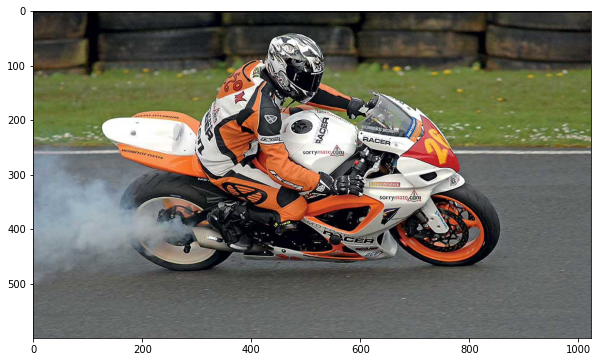

In [38]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        if image.mode != "RGB":
            image = image.convert("RGB")
        image = image.resize((224, 224))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        feature = model.predict(image)
        return feature


max_length=31
img_path = "../input/myimages/bike.jpeg"

vgmodel=VGG16()
vgmodel.layers.pop()
vgmodel = Model(inputs=vgmodel.inputs, outputs=vgmodel.layers[-2].output)

photo = extract_features(img_path, vgmodel)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
description = remove_repeated_words(description)
description = description.replace('start_', '').replace('_end', '')

print(description)
plt.figure(figsize=(10, 10))
plt.imshow(img)